# Transformation of Raw Scores Data


**This notebook is a part of Davor Penzar's *[ESC](http://eurovision.tv/) Score Predictor* project.**

Author: [Davor Penzar `<davor.penzar@gmail.com>`](mailto:davor.penzar@gmail.com)\
Date: $ 14 $<sup>th</sup> December $ 2020 $\
Version: `1.0`


This [*Jupyter notebook*](http://jupyter.org/) transforms raw scores data into the format that is used throughout the rest of the project.


## Environment Preparation


Import library&hellip;


In [1]:
# Import IPython.
from IPython import *
from IPython.display import *


In [2]:
# Import standard library.
import csv


In [3]:
# Import SciPy packages.
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
#import sympy as sym
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D


Initial setup&hellip;


In [4]:
%matplotlib inline


In [5]:
#sym.init_printing()


In [6]:
plt.style.use('default')


**[*Python*](http://python.org/) version and versions of packages**

Output on the original machine:

```
Python version:
	3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
SciPy version: 1.5.0
NumPy version: 1.18.5
Pandas version: 1.0.5
Matplotlib version: 3.2.2

```


In [7]:
print(
    "Python version:\n\t{v:s}".format(
        v = sys.version.strip().replace("\n", "\n\t")
    )
)
print("SciPy version: {v:s}".format(v = sp.__version__))
print("NumPy version: {v:s}".format(v = np.__version__))
print("Pandas version: {v:s}".format(v = pd.__version__))
print("Matplotlib version: {v:s}".format(v = mpl.__version__))


Python version:
	3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
SciPy version: 1.5.0
NumPy version: 1.18.5
Pandas version: 1.0.5
Matplotlib version: 3.2.2


## Importing Raw Data


We shall import the raw data downloaded at [[3]](#bib-Okhuijsen19) with minimal manipulation during the importing (see parameters `names` and `converters` in [`pd.read_excel` function](http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html) call below).


In [8]:
# Read data from the Excel spreadsheet.
df = pd.read_excel(
    'data/eurovision_song_contest_1975_2019v3.xlsx',
    sheet_name = 'Data',
    header = 0,
    names = [
        'year',
        'contest_level',
        'edition',
        'by',
        'from',
        'to',
        'points',
        'duplicate'
    ],
    index_col = None,
    converters = {
        'contest_level': (
            lambda l:
                'semifinal' if l.upper() in {'SF', 'SF1', 'SF2'}
                else 'final' if l.upper() == 'F'
                else None
        ),
        'by': (
            lambda s:
                'jury' if s.upper() == 'J'
                else 'televoting' if s.upper() == 'T'
                else None
        ),
        'duplicate': (
            lambda d:
                True if d.upper() == 'X'
                else False if not d
                else None
        )
    }
)


The dataframe now holds information about scoring points in all contests (at all levels&mdash;both semifinal and final), as well as who gave them and who received them.


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49832 entries, 0 to 49831
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year           49832 non-null  int64 
 1   contest_level  49832 non-null  object
 2   edition        49832 non-null  object
 3   by             49832 non-null  object
 4   from           49832 non-null  object
 5   to             49832 non-null  object
 6   points         49832 non-null  int64 
 7   duplicate      49832 non-null  bool  
dtypes: bool(1), int64(2), object(5)
memory usage: 2.7+ MB


In [10]:
df.sample(12, replace = False, random_state = 2020).sort_index()


,year,contest_level,edition,by,from,to,points,duplicate
3503,1984,final,1984f,jury,Sweden,Belgium,0,False
4988,1988,final,1988f,jury,Greece,Belgium,0,False
8071,1994,final,1994f,jury,France,Malta,0,False
8473,1994,final,1994f,jury,Switzerland,Poland,10,False
9305,1996,final,1996f,jury,Ireland,Poland,0,False
10921,1999,final,1999f,jury,Croatia,Israel,8,False
12992,2002,final,2002f,jury,Switzerland,Latvia,8,False
27536,2011,final,2011f,jury,Spain,Lithuania,1,False
30892,2013,final,2013f,jury,Israel,Greece,2,False
32326,2014,final,2014f,jury,Georgia,Spain,0,False


However, such detailed information is redundant. All we really need is how much each country scored in total. Furthermore, we are not interested in semifinals because score distribution would then be inconsistent and the consistency would be hard, if not impossible, to recreate.


## Reduction of Unnecessary Data


We shall now simplify the dataframe in a more compact and useful format, as mentioned before.


In [11]:
# Drop unnecessary rows and columns.
df.dropna(axis = 0, how = 'any', inplace = True)
df.drop(
    df.index[df.contest_level != 'final'],
    axis = 0,
    inplace = True
)
df.drop(
    ['contest_level', 'edition', 'by', 'from', 'duplicate'],
    axis = 1,
    inplace = True
)

# Aggregate by the accumulated score.
df = df.groupby(
    ['to', 'year'],
    axis = 0,
    sort = False
).sum().reset_index(
    drop = False,
    inplace = False,
    col_fill = None
)
df.columns = ['country', 'year', 'score']
df.sort_values(
    ['year', 'country', 'score'],
    axis = 0,
    ascending = [True, True, False],
    inplace = True
)
df.reset_index(drop = True, inplace = True)

# Create a new dataframe to ensure its internal memory optimisation.
df = df.copy(deep = True)


Let us observe the current state of the dataframe.


In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032 entries, 0 to 1031
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   country  1032 non-null   object
 1   year     1032 non-null   int64 
 2   score    1032 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 24.3+ KB


In [13]:
df.sample(12, replace = False, random_state = 2020).sort_index()


,country,year,score
39,Finland,1977,50
297,Denmark,1990,64
318,Cyprus,1991,60
322,Germany,1991,10
352,Norway,1992,23
369,Germany,1993,18
386,Austria,1994,19
612,Israel,2003,17
869,Russia,2013,174
872,The Netherlands,2013,114


The number of entries (rows) dropped drastically, from $ 49832 $ to $ 1032 $ (by $ 97.93 \, \% $). The dataframe is now more informant<sup>[1](#footnote-1)</sup>, too: for instance, if we want to know how much France scored in $ 1995 $ finals, all we need to do is find `df.loc[(df.country == 'France') & (df.year == 1995), 'score']` (in the earlier format, a group-by and an aggregate function were needed to obtain the information).

---

<a class="anchor" id="footnote-1"></a><sup>1</sup> Of course, one can argue that the original dataframe was more *informant* since it held more details and therefore more information. However, in the context of this project, the relevant data is actually total score of each country in the finals, which will be normalised later. Since this dataframe now explicitly holds such information, it is considered more informant than the original one.


In [14]:
int(df.loc[(df.country == 'France') & (df.year == 1995), 'score'])


94

## Adding Missing Years


Observe that the dataframe starts at year $ 1975 $.


In [15]:
df.year.min()


1975

However, the Contest started earlier, in year $ 1956 $. The official database at [[1]](#bib-ESCDB) holds records of scores from the beginning, since year $ 1957 $. As it is mentioned at [[2]](#bib-EVW), voting was secret in year $ 1956 $, while the voting/scoring system changed in year $ 1975 $ and remained relatively unchanged since (which is probably why [[3]](#bib-Okhuijsen19) holds only records starting from year $ 1975 $). The author gathered data from years $ 1957 $&ndash;$ 1974 $ into a new spreadsheet which we shall now incorporate.


In [16]:
# Join the dataframe with missing years.
df = pd.concat(
    (
        pd.read_excel(
            'data/eurovision_song_contest_1957_1974.xlsx',
            sheet_name = 'Data',
            header = 0,
            names = df.columns,
            index_col = None
        ),
        df
    ),
    axis = 0,
    ignore_index = True
)
df.sort_values(
    ['year', 'country', 'score'],
    axis = 0,
    ascending = [True, True, False],
    inplace = True
)
df.reset_index(drop = True, inplace = True)

# Create a new dataframe to ensure its internal memory optimisation.
df = df.copy(deep = True)


Of course, information about the dataframe's size and data has changed again.


In [17]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   country  1308 non-null   object
 1   year     1308 non-null   int64 
 2   score    1308 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 30.8+ KB


In [18]:
df.sample(12, replace = False, random_state = 2020).sort_index()


,country,year,score
44,Austria,1961,1
51,Luxembourg,1961,31
194,Belgium,1970,5
279,Germany,1975,15
409,Austria,1982,57
820,Malta,2000,73
861,Finland,2002,24
1017,Russia,2008,272
1135,Greece,2013,152
1190,Israel,2015,97


In the end, the dataframe holds $ 1308 $ entries, meaning $ 276 $ ($ {+ 26.74} \, \% $ more than before, $ 21.10 \, \% $ of total) entries of missing years were added.


## Names of Countries


Let us observe the names of all countries appearing in the dataframe-


In [19]:
np.sort(np.asarray(df.country.unique()).ravel()).tolist()


['Albania',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Belarus',
 'Belgium',
 'Bosnia & Herzegovina',
 'Bulgaria',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Estonia',
 'F.Y.R. Macedonia',
 'Finland',
 'France',
 'Georgia',
 'Germany',
 'Greece',
 'Hungary',
 'Iceland',
 'Ireland',
 'Israel',
 'Italy',
 'Latvia',
 'Lithuania',
 'Luxembourg',
 'Malta',
 'Moldova',
 'Monaco',
 'Montenegro',
 'Morocco',
 'North Macedonia',
 'Norway',
 'Poland',
 'Portugal',
 'Romania',
 'Russia',
 'San Marino',
 'Serbia',
 'Serbia & Montenegro',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden',
 'Switzerland',
 'The Netherlands',
 'Turkey',
 'Ukraine',
 'United Kingdom',
 'Yugoslavia']

As we can see, some of the countries no longer exist (Yugoslavia, Serbia and Montenegro) or they are named differently now (FYR Macedonia).

We shall now change entries of such countries by using the current countries' names. In case of now broken-up federations and unions (Yugoslavia, Serbia and Montenegro) the names of current countries of origin of contestants shall be used. This information was found by browsing [*Wikipedia*](http://wikipedia.org/).


In [20]:
# **Note.** The following collections in no way represent the author's
# political or any other views nor do they imply existence or non-existence of
# any state / validity or non-validity of its statehood.  The information is
# gathered from actual history which, without a doubt, happend while the
# variables are only named associatively to make the source code more readable.

Yugoslavia = frozenset(
    {
        'Yugoslavia',
        'Serbia & Montenegro',
        'Bosnia & Herzegovina',
        'Croatia',
        'Kosovo',
        'Montenegro',
        'F.Y.R. Macedonia',
        'North Macedonia',
        'Serbia',
        'Slovenia'
    }
)
SerbiaAndMontenegro = frozenset(
    {
        'Serbia & Montenegro',
        'Kosovo',
        'Montenegro',
        'Serbia'
    }
)
BosniaAndHerzegovina = frozenset(
    {
        'Bosnia & Herzegovina'
    }
)
Croatia = frozenset(
    {
        'Croatia'
    }
)
Kosovo = frozenset(
    {
        'Kosovo'
    }
)
Montenegro = frozenset(
    {
        'Montenegro'
    }
)
Macedonia = frozenset(
    {
        'F.Y.R. Macedonia',
        'North Macedonia'
    }
)
Serbia = frozenset(
    {
        'Serbia',
        'Kosovo'
    }
)
Slovenia = frozenset(
    {
        'Slovenia'
    }
)


In [21]:
df.loc[df.country.isin(Yugoslavia)].sample(12, replace = False, random_state = 2020).sort_index()


,country,year,score
258,Yugoslavia,1973,65
569,Yugoslavia,1989,137
759,Croatia,1998,131
776,Slovenia,1998,17
785,Bosnia & Herzegovina,1999,86
808,Croatia,2000,70
896,Slovenia,2003,7
907,Croatia,2004,50
992,Serbia,2007,268
1164,Montenegro,2014,37


In [22]:
df.loc[(df.country == 'Yugoslavia') & (df.year == 1961), 'country'] = 'Serbia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1962), 'country'] = 'Serbia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1963), 'country'] = 'Croatia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1964), 'country'] = 'Bosnia & Herzegovina'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1965), 'country'] = 'Croatia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1966), 'country'] = 'Slovenia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1967), 'country'] = 'Slovenia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1968), 'country'] = 'Croatia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1969), 'country'] = 'Croatia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1970), 'country'] = 'Slovenia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1971), 'country'] = 'Croatia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1972), 'country'] = 'Croatia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1973), 'country'] = 'Bosnia & Herzegovina'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1974), 'country'] = 'Serbia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1975), 'country'] = 'Slovenia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1976), 'country'] = 'Bosnia & Herzegovina'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1981), 'country'] = 'Bosnia & Herzegovina'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1982), 'country'] = 'Serbia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1983), 'country'] = 'Montenegro'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1984), 'country'] = 'Croatia' # see commentary below
df.loc[(df.country == 'Yugoslavia') & (df.year == 1986), 'country'] = 'Croatia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1987), 'country'] = 'Croatia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1988), 'country'] = 'Croatia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1989), 'country'] = 'Croatia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1990), 'country'] = 'Croatia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1991), 'country'] = 'Serbia'
df.loc[(df.country == 'Yugoslavia') & (df.year == 1992), 'country'] = 'Serbia'
df.loc[(df.country == 'Serbia & Montenegro') & (df.year == 2004), 'country'] = 'Serbia'
df.loc[(df.country == 'Serbia & Montenegro') & (df.year == 2005), 'country'] = 'Montenegro'
df.loc[df.country == 'F.Y.R. Macedonia', 'country'] = 'North Macedonia'


**Commentary**

1.  In year $ 1984 $ Yugoslavian contestants were a duo consisting of Croatian male singer **Vlado Kalember** and Serbian female singer **Izolda Barudžija**. However, the official database states the performer(s) at [[1]](#bib-ESCDB) as *Vlado and Isolda*, giving Vlado Kalember precedence.


The sample from the dataframe given above now looks as following.


In [23]:
df.loc[df.country.isin(Yugoslavia)].sample(12, replace = False, random_state = 2020).sort_index()


,country,year,score
258,Bosnia & Herzegovina,1973,65
569,Croatia,1989,137
759,Croatia,1998,131
776,Slovenia,1998,17
785,Bosnia & Herzegovina,1999,86
808,Croatia,2000,70
896,Slovenia,2003,7
907,Croatia,2004,50
992,Serbia,2007,268
1164,Montenegro,2014,37


Finally, to simplify names of countries, we shall employ one more mapping.


In [24]:
df.loc[df.country == 'Bosnia & Herzegovina', 'country'] = 'Bosnia and Herzegovina'
df.loc[df.country == 'Serbia & Montenegro', 'country'] = 'Serbia and Montenegro'
df.loc[df.country == 'The Netherlands', 'country'] = 'Netherlands'


Let us make sure our job is done here.


In [25]:
np.sort(np.asarray(df.country.unique()).ravel()).tolist()


['Albania',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Belarus',
 'Belgium',
 'Bosnia and Herzegovina',
 'Bulgaria',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Estonia',
 'Finland',
 'France',
 'Georgia',
 'Germany',
 'Greece',
 'Hungary',
 'Iceland',
 'Ireland',
 'Israel',
 'Italy',
 'Latvia',
 'Lithuania',
 'Luxembourg',
 'Malta',
 'Moldova',
 'Monaco',
 'Montenegro',
 'Morocco',
 'Netherlands',
 'North Macedonia',
 'Norway',
 'Poland',
 'Portugal',
 'Romania',
 'Russia',
 'San Marino',
 'Serbia',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden',
 'Switzerland',
 'Turkey',
 'Ukraine',
 'United Kingdom']

## Normalisation of Scores


Let us observe the distribution of scores amongst countries (contestants) over the years.


In [26]:
scores = df.loc[:, ['year', 'score']].groupby('year').describe()
scores.sample(12, replace = False, random_state = 2020).sort_index()


score                                                        
     count       mean        std   min    25%   50%     75%    max
year                                                              
1957  10.0  10.000000   8.313309   3.0   5.25   7.5    9.50   31.0
1969  16.0  10.000000   5.573748   1.0   5.75   9.0   14.25   18.0
1970  12.0  10.666667   8.917127   4.0   5.00   8.0    9.00   32.0
1975  19.0  58.000000  44.289452   3.0  19.50  53.0   80.50  152.0
1980  19.0  58.000000  41.964271   6.0  24.00  47.0   90.00  143.0
1982  18.0  58.000000  41.639913   0.0  23.75  54.5   83.25  161.0
1993  25.0  58.000000  53.556823   3.0  17.00  42.0   89.00  187.0
1994  25.0  58.000000  55.372978   0.0  15.00  48.0   74.00  226.0
1999  23.0  58.000000  48.473986   1.0  17.50  38.0   88.00  163.0
2008  25.0  99.760000  73.697739  14.0  47.00  69.0  138.00  272.0
2010  25.0  90.480000  60.446340  10.0  41.00  72.0  141.00  246.0
2014  26.0  82.538462  73.203951   2.0  35.50  63.0   88.75  290.0

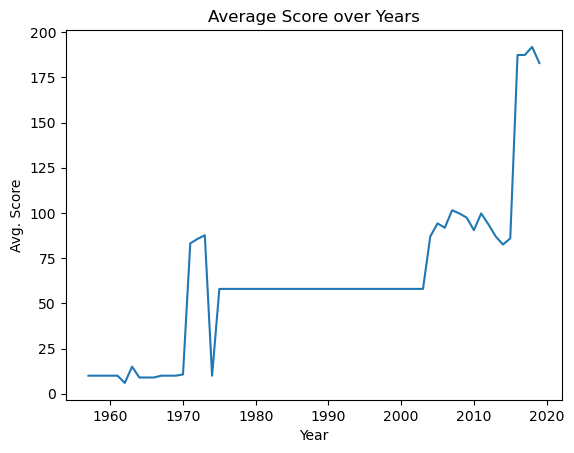

In [27]:
ax = plt.gca()
ax.plot(
    scores.index,
    scores[('score', 'mean')],
    marker = 'None',
    linestyle = '-'
)
ax.set_title('Average Score over Years')
ax.set_xlabel('Year')
ax.set_ylabel('Avg. Score')
plt.show()


In [28]:
scores_by_count = df.loc[:, ['year', 'score']].groupby('year').apply(lambda x: x['score'] / x['score'].count()).to_frame().reset_index(level = 0).loc[:, ['year', 'score']].groupby('year').describe()
scores_by_count.sample(12, replace = False, random_state = 2020).sort_index()


score                                                              \
     count      mean       std       min       25%       50%       75%   
year                                                                     
1957  10.0  1.000000  0.831331  0.300000  0.525000  0.750000  0.950000   
1969  16.0  0.625000  0.348359  0.062500  0.359375  0.562500  0.890625   
1970  12.0  0.888889  0.743094  0.333333  0.416667  0.666667  0.750000   
1975  19.0  3.052632  2.331024  0.157895  1.026316  2.789474  4.236842   
1980  19.0  3.052632  2.208646  0.315789  1.263158  2.473684  4.736842   
1982  18.0  3.222222  2.313328  0.000000  1.319444  3.027778  4.625000   
1993  25.0  2.320000  2.142273  0.120000  0.680000  1.680000  3.560000   
1994  25.0  2.320000  2.214919  0.000000  0.600000  1.920000  2.960000   
1999  23.0  2.521739  2.107565  0.043478  0.760870  1.652174  3.826087   
2008  25.0  3.990400  2.947910  0.560000  1.880000  2.760000  5.520000   
2010  25.0  3.619200  2.417854  0.400000  1.640000  2.880000  5.640000   
2014  26.0  3.174556  2.815537  0.076923  1.365385  2.423077  3.413462   

                 
            max  
year             
1957   3.100000  
1969   1.125000  
1970   2.666667  
1975   8.000000  
1980   7.526316  
1982   8.944444  
1993   7.480000  
1994   9.040000  
1999   7.086957  
2008  10.880000  
2010   9.840000  
2014  11.153846

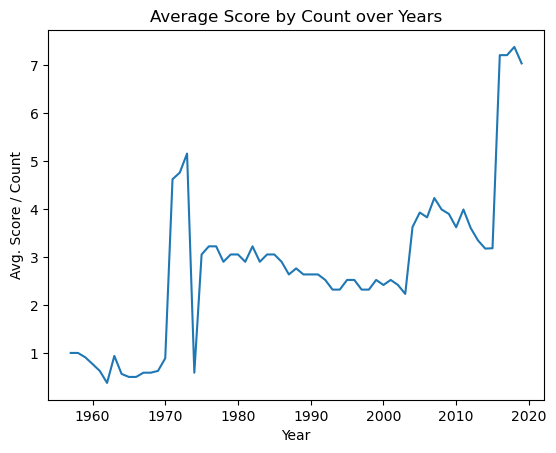

In [29]:
ax = plt.gca()
ax.plot(
    scores_by_count.index,
    scores_by_count[('score', 'mean')],
    marker = 'None',
    linestyle = '-'
)
ax.set_title('Average Score by Count over Years')
ax.set_xlabel('Year')
ax.set_ylabel('Avg. Score / Count')
plt.show()


Both of the tables above display distribution of scores through (selected) years; the plots are related. Difference is that the first one shows absolute scores while the second one shows relative scores&mdash;scores divided by the total number of contestants (or finalists where applicable). As one can see, neither of the tables is constant/consistent, not even in the `mean` column.

The phenomenon observed above suggests that a normalisation of scores is necessary to ensure the meaning of data is somewhat consistent throughout the years (a score of $ 100 $ points had a different meaning in years $ 1980 $ and $ 2010 $). The selected normalisation method is to divide each score by average score in the given year.


In [30]:
mean_score = df.loc[:, ['year', 'score']].groupby('year').mean().squeeze()
df['nscore'] = df.score / mean_score[df.year].reset_index(drop = True)


Column `nscore` (*normalised score*) is now much more consistent, as we can see below. The first table displays a sample from the dataframe and the second one displays its distribution through years.


In [31]:
df.sample(12, replace = False, random_state = 2020).sort_index()


,country,year,score,nscore
44,Austria,1961,1,0.100000
51,Luxembourg,1961,31,3.100000
194,Belgium,1970,5,0.468750
279,Germany,1975,15,0.258621
409,Austria,1982,57,0.982759
820,Malta,2000,73,1.258621
861,Finland,2002,24,0.413793
1017,Russia,2008,272,2.726544
1135,Greece,2013,152,1.747126
1190,Israel,2015,97,1.128879


In [32]:
df.loc[:, ['year', 'nscore']].groupby('year').describe().sample(12, replace = False, random_state = 2020).sort_index()


nscore                                                                 
      count mean       std       min       25%       50%       75%       max
year                                                                        
1957   10.0  1.0  0.831331  0.300000  0.525000  0.750000  0.950000  3.100000
1969   16.0  1.0  0.557375  0.100000  0.575000  0.900000  1.425000  1.800000
1970   12.0  1.0  0.835981  0.375000  0.468750  0.750000  0.843750  3.000000
1975   19.0  1.0  0.763611  0.051724  0.336207  0.913793  1.387931  2.620690
1980   19.0  1.0  0.723522  0.103448  0.413793  0.810345  1.551724  2.465517
1982   18.0  1.0  0.717930  0.000000  0.409483  0.939655  1.435345  2.775862
1993   25.0  1.0  0.923394  0.051724  0.293103  0.724138  1.534483  3.224138
1994   25.0  1.0  0.954707  0.000000  0.258621  0.827586  1.275862  3.896552
1999   23.0  1.0  0.835758  0.017241  0.301724  0.655172  1.517241  2.810345
2008   25.0  1.0  0.738750  0.140337  0.471131  0.691660  1.383320  2.726544
2010   25.0  1.0  0.668063  0.110522  0.453139  0.795756  1.558355  2.718833
2014   26.0  1.0  0.886907  0.024231  0.430103  0.763281  1.075256  3.513514

## Numbers of Contestants


In the end, let us count how many contestants were in each year. This is not actually transformation of the dataframe, but this information will be used in other parts of the project.


In [33]:
count = df.loc[:, ['year', 'country']].groupby('year').count().rename({'country': 'n'}, axis = 1)


In [34]:
count.sample(12, replace = True, random_state = 2020).sort_index()


,n
year,
1960,13
1960,13
1960,13
1964,16
1965,18
1984,19
1986,20
1989,22
2005,24


In [35]:
count.describe()


,n
count,63.000000
mean,20.761905
std,4.402031
min,10.000000
25%,18.000000
50%,22.000000
75%,25.000000
max,27.000000


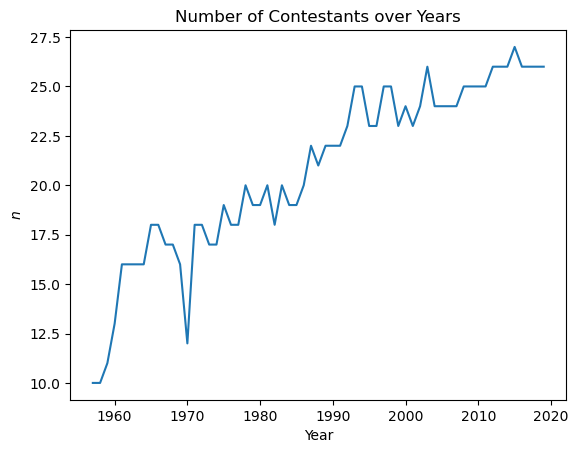

In [36]:
ax = plt.gca()
ax.plot(
    count.index,
    count['n'],
    marker = 'None',
    linestyle = '-'
)
ax.set_title('Number of Contestants over Years')
ax.set_xlabel('Year')
ax.set_ylabel("$ n $")
plt.show()


## Saving Transformed Data


The only thing left to do is to save the resulting dataframe to outer memory. We shall save the dataframe in the same directory where raw data is.


In [37]:
df.to_csv('data/scores.csv', sep = ';', float_format = '%.8f', header = True, index = False, encoding = 'ascii', quoting = csv.QUOTE_NONNUMERIC)


# References


1.  <a class="anchor" id="bib-ESCDB"></a>Eurovision Song Contest, *Eurovision Song Contest database*, Web page, Geneva: European Broadcasting Union, 2020. [Online]. Available: [http://eschome.net/](http://eschome.net/) (visited on 15/12/2020).
2.  <a class="anchor" id="bib-EVW"></a>Eurovisionworld, *Eurovision voting &amp; points*, Web page, Eurovisionworld, 2020. [Online]. Available: [http://eurovisionworld.com/eurovision](http://eurovisionworld.com/eurovision) (visited on 15/12/2020).
3.  <a class="anchor" id="bib-Okhuijsen19"></a>S. Okhuijsen, *Eurovision Song Contest scores $ 1975 $&ndash;$ 2019$*, Web page, Utrecht: Datagraver, 2019. [Online]. Available: [http://data.world/datagraver/eurovision-song-contest-scores-1975-2019](http://data.world/datagraver/eurovision-song-contest-scores-1975-2019) (visited on 19/08/2020).
